In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import inspect
import os
import sys
import time

import paragami
import vittles

from copy import deepcopy

import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

np.random.seed(42) # nothing special about this seed (we hope)!

In [2]:
#fitfile = './fits/transformed_gene_regression_df7_degree3_genes700_num_components100_fit.npz'
fitfile = './fits/transformed_gene_regression_df4_degree3_genes700_num_components30_fit.npz'
with np.load(fitfile) as infile:
    gmm_params_pattern = paragami.get_pattern_from_json(
        str(infile['gmm_params_pattern_json']))
    opt_gmm_params = gmm_params_pattern.fold(
        infile['opt_gmm_params_flat'], free=False)
    prior_params_pattern = paragami.get_pattern_from_json(
        str(infile['prior_params_pattern_json']))
    prior_params = prior_params_pattern.fold(
        infile['prior_params_flat'], free=False)
    kl_hess = infile['kl_hess']
    df = infile['df']
    degree = infile['degree']
    datafile = str(infile['datafile'])
    num_components = int(infile['num_components'])

reg_params = dict()
with np.load(datafile) as infile:
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']

print(kl_hess.shape)

(238, 238)


In [36]:
new_alpha = 10.0
new_prior_params = deepcopy(prior_params)
new_prior_params['probs_alpha'][:] = new_alpha

gmm = gmm_lib.GMM(num_components, new_prior_params, reg_params)

print('Setting preconditioner...')
gmm.get_kl_conditioned.set_preconditioner_with_hessian(
    hessian=kl_hess, ev_min=1e-6)
print('Done.')

init_x = gmm.gmm_params_pattern.flatten(opt_gmm_params, free=True)

print('Optimizing...')
gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x, verbose=True, kl_hess=kl_hess)
opt_time = time.time() - tic
print('Done.')
print('Re-optimization time: {} seconds'.format(opt_time))

Setting preconditioner...
Done.
Optimizing...
Iter 0: f = -9643.84699857
Preconditioned iteration 1
  Taking Newton step.
Iter 1: f = -9643.84699857
Iter 2: f = -9612.43900321
-31.407995361792928
Iter 3: f = -9612.43900321
Shrinking step.
Iter 4: f = -9673.37861270
29.531614137427823
Iter 5: f = -9673.37861270
Success.
  Running preconditioned optimization.
Iter 0: f = -9673.37861270
Iter 1: f = -9681.30586351
Iter 2: f = -9681.93179274
Iter 3: f = -9684.54660526
Iter 4: f = -9687.28285437
Iter 5: f = -9690.15450859
Iter 6: f = -9693.38524928
Iter 7: f = -9694.49981266
Iter 8: f = -9697.73497208
Iter 9: f = -9698.23935535
Iter 10: f = -9640.40948460
Iter 11: f = -9697.89859607
Iter 12: f = -9698.92312415
Iter 13: f = -9699.55003148
Iter 14: f = -9700.98441101
Iter 15: f = -9701.97124792
Iter 16: f = -9703.67719401
Iter 17: f = -9704.83045291
Iter 18: f = -9705.37942643
Iter 19: f = -9705.63316417
Iter 20: f = -9705.70335513
Iter 21: f = -9705.82216974
Iter 22: f = -9706.08057544
Iter 2

4.724331092199248

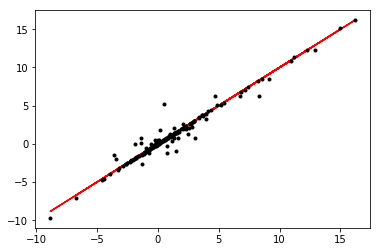

In [4]:
reopt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)
def comparison_plot(x, y):
    plt.plot(x, x, 'r')
    plt.plot(x, y, 'k.')
    
comparison_plot(opt_gmm_params['centroids'], reopt_gmm_params['centroids'])
np.max(np.abs((opt_gmm_params['centroids'] - reopt_gmm_params['centroids'])))

0.999876043931594

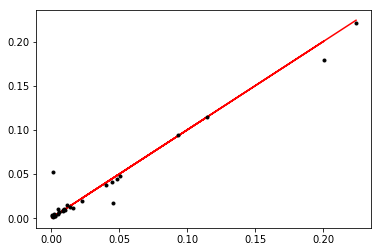

In [5]:
e_z0 = gmm.get_e_z(opt_gmm_params)
e_z1 = gmm.get_e_z(reopt_gmm_params)

comparison_plot(np.mean(e_z0, axis=0), np.mean(e_z1, axis=0))
np.max(np.abs(e_z0 - e_z1))

In [13]:
from bnpmodeling_runjingdev.cluster_quantities_lib import get_e_num_large_clusters_from_ez
n_samples = 1000
threshold = 1
unif_samples = np.random.random((gmm.num_obs, n_samples))

e_num0, var_num0 = get_e_num_large_clusters_from_ez(
    e_z0,
    threshold = threshold,
    n_samples = None,
    unif_samples = unif_samples)

e_num1, var_num1 = get_e_num_large_clusters_from_ez(
    e_z1,
    threshold = threshold,
    n_samples = None,
    unif_samples = unif_samples)

print('Refit e:\t{}\nOrig e: \t{}\nDifference:\t{}\nSds:\t\t{}, {}'.format(
    e_num1, e_num0, e_num1 - e_num0, np.std(var_num0), np.std(var_num1)))

Refit e:	27.539
Orig e: 	23.972
Difference:	3.567
Sds:		0.0, 0.0


In [23]:
get_kl_from_vb_free_prior_free = \
    paragami.FlattenFunctionInput(original_fun=
        gmm.get_params_prior_kl,
        patterns = [gmm.gmm_params_pattern, prior_params_pattern],
        free = [True, True],
        argnums = [0, 1])

gmm.get_params_prior_kl(opt_gmm_params, prior_params)

get_kl_from_vb_free_prior_free(
    gmm.gmm_params_pattern.flatten(opt_gmm_params, free=True),
    prior_params_pattern.flatten(prior_params, free=True))

-9767.30114247451

In [45]:
taylor_order = 1
t0 = time.time()
vb_sens = \
    vittles.ParametricSensitivityTaylorExpansion(
        objective_function =    get_kl_from_vb_free_prior_free,
        input_val0 =            gmm.gmm_params_pattern.flatten(opt_gmm_params, free=True),
        hyper_val0 =            prior_params_pattern.flatten(prior_params, free=True),
        order =                 taylor_order,
        hess0 =                 kl_hess)
print('linear response Hessian time: {:.03f} secs'.format(time.time() - t0))

linear response Hessian time: 0.008 secs


In [46]:
predict_gmm_params = \
    paragami.FoldFunctionInputAndOutput(
        original_fun=vb_sens.evaluate_taylor_series,
        input_patterns=prior_params_pattern,
        input_free=True,
        input_argnums=[0],
        output_patterns=gmm.gmm_params_pattern,
        output_free=True,
        output_retnums=[0])

pred_gmm_params = predict_gmm_params(new_prior_params)
e_z1_pred = gmm.get_e_z(pred_gmm_params)

e_num_pred, var_num_pred = get_e_num_large_clusters_from_ez(
    e_z1_pred,
    threshold = threshold,
    n_samples = None,
    unif_samples = unif_samples)

print('Orig e: \t{}\nRefit e:\t{}\nPred e:\t\t{}\nSds:\t\t{}, {}'.format(
    e_num0, e_num1, e_num_pred, np.std(var_num0), np.std(var_num1)))

Orig e: 	23.972
Refit e:	27.539
Pred e:		25.566
Sds:		0.0, 0.0
